# ID2222 Data Mining, Homework 3
# **Mining Data Streams - TRIEST BASE**

Brando Chiminelli, Tommaso Praturlon

November 28th, 2022

## Goal
The goal of this notebook is to mine streams of data, in particular algorithms for processing streaming graph.

Here we reproduced the algorithm described in <a href="TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size">"L. De Stefani, A. Epasto, M. Riondato, and E. Upfal, TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size, KDD'16"</a>. In particular, we implemented TRIÈST-BASE and TRIÈST-IMPR.

They study the problem of counting global and local triangles in a fully-dynamic undirected graph as an arbitrary (adversarial) stream of edge insertions and deletions. Both the Triest-Base and Impr algorithm work on insertion-only streams.

The algorithms were then tested first on the <a href="https://snap.stanford.edu/data/web-Stanford.html">Stanford web graph</a> and then on the <a href="https://snap.stanford.edu/data/ego-Facebook.html">Social circles: Facebook network</a> to assess correctness and performance.

## How to run

In order to run this notebook you need to import the dataset Social circles Facebook network in a 'data/' directory. Then you can run all the notebook and read along the descriptions of the different parts of the implementation and check the comments present on the code.

## Import libraries and read the dataset
In the following we import the few libraries needed for the project and we read the dataset.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

#PATH_TO_DATA = "../data/web-Stanford.txt"
PATH_TO_DATA = "../data/facebook_combined.txt"
df_graphs = pd.read_csv(PATH_TO_DATA, header=None)
print("Data read successfully!")

# Reduce dataset size for computation overload (temporary)
#df_graphs = df_graphs.iloc[0:50000]
print(df_graphs.head())
print("Number of rows: ", len(df_graphs))

Data read successfully!
     0
0  0 1
1  0 2
2  0 3
3  0 4
4  0 5
Number of rows:  88234


## Data Wrangling

In the following we want to transorm our dataset to make it more clean to read and process.

We do that both for the Social circles Facebook dataset and for the Stanford web graph, by removing some rows that are not needed (general statistics about the data) and converting the values into integers.

In [76]:
# DATA WRANGLING FACEBOOK

df_g = df_graphs
data = []
for i in range(len(df_g)):
    # make the two elements a tuple
    s = tuple(str(df_g.iloc[i][0]).split(' '))
    data.append(s)
#print(data)

In [ ]:
'''
# DATA WRANGLING STANFORD

df_g = df_graphs.drop([0, 1, 2, 3, 4])
data = []
for i in range(len(df_g)):
    s = [int(x) for x in str(df_g.iloc[i][0]).split('\t')]
    data.append(s)
#print(data)
'''

## TRIEST BASE Class

Our implementation of the Triest Base class has three main functions:

- **run_triest** which takes one edge at a time from our dataset as a stream, run the algorithm and return the counters and the estimated value of triangles.

- **sampleEdge** uses the reservoir sampling process to update the edge sample, and each edge item in the sample has equal probability of being removed.

- **updateCounters** to update (increments / decrements) the values of the global and local counters,


In [78]:
####################################
# TRIEST-BASE CLASS IMPLEMENTATION #
####################################

class TriestBase:
    '''
    Implementation of the Trièst-base algorithm
    - function SampleEdge
    - function UpdateCounter
    - function FlipBiasedCoin
    '''
    
    def __init__(self,M):
        self._M = M
        self._tau = 0
        self._tau_loc = {}
        self._t = 0
        self._S = set()
        self._tau_ls = []
        
    def flipBiasedCoin(self, M, t):
        '''
        Flip a biased coin with probability M/t of falling head.
        '''
        # 1: head, 0: tail
        result = np.random.choice([1, 0], p=[M/t, (1-M/t)])

        if result:
            return True
        else:
            return False
    
    def sampleEdge(self, edge, t):
        '''
        Receives the edge (u,v) as [u, v] and time t at which
        the stream element is received. t is a count integer.
        Returns a boolean
        '''        
        # when t <= M, the edge is deterministically inserted in S
        if (t <= self._M):
            return True
        elif self.flipBiasedCoin(self._M, t):
            # select random edge from S
            random_edge = random.choice(tuple(self._S))
            # Delete random_edge from S
            self._S.remove(random_edge)
            # Update counters
            self.updateCounters('delete', random_edge)
            return True
        else:
            return False
            
    def updateCounters(self, operation, edge):
        '''
        Receives the operation insertion or deletion
        and the edge.
        tau is the global counter
        e.g S = [[5,10], [10, 3], [12, 5], [12, 3]]
        edge = (5, 12)
        N_5 = (10, 12)
        N_12 = (5, 3)
        N_5_12 = (5, 12)
        '''
        # Define shared-neighborhood
        shared_neigh = set()
        neigh_u = set() # all neighbors of edge[0]
        neigh_v = set() # all nneighbors of edge[1]

        u = edge[0]
        v = edge[1]
        for elem in self._S:
            # check that for the v in V_t (u,v) belongs to S
            # create neigh_u
            if u == elem[0]: # found u in position 0
                neigh_u.add(elem[1]) # add the other element
            if u == elem[1]: # found u in position 1
                neigh_u.add(elem[0]) # add the other element
            # create neigh_v
            if v == elem[0]: # found v in position 0
                neigh_v.add(elem[1]) 
            if v == elem[1]: # found v in position 1
                neigh_v.add(elem[0])
        # shared neighbourhood is the intersection between the sets
        shared_neigh = set.intersection(neigh_u, neigh_v)
        self._tau_ls.append(self._tau)
        if operation == 'insert':
            # Insert
            for c in shared_neigh:
                self._tau += 1
                self._tau_loc[c] = self._tau_loc.get(c, 0) + 1
                self._tau_loc[u] = self._tau_loc.get(u, 0) + 1
                self._tau_loc[v] = self._tau_loc.get(v, 0) + 1
        else:
            # Delete
            for c in shared_neigh:
                self._tau -= 1
                self._tau_loc[c] = self._tau_loc.get(c, 0) - 1
                if self._tau_loc[c] <= 0:
                    del self._tau_loc[c]
                self._tau_loc[u] = self._tau_loc.get(u, 0) - 1
                if self._tau_loc[u] <= 0:
                    del self._tau_loc[u]
                self._tau_loc[v] = self._tau_loc.get(v, 0) - 1
                if self._tau_loc[v] <= 0:
                    del self._tau_loc[v]
        
                    
    def run_triest(self, data):
        print("Number of edges: ", len(data))
        for edge in data:
            self._t += 1
            if self.sampleEdge(edge, self._t):
                self._S.add(edge)
                self.updateCounters('insert', edge)
                
        # Return counters
        eps = max(1, (self._t * (self._t - 1) * (self._t - 2))/(self._M * (self._M - 1) * (self._M - 2)))
        print("tau: ", self._tau)
        print("eps: ", eps)
        est_tri = self._tau*eps
        print("Estimated triangles: ", est_tri)
        plt.plot(range(len(self._tau_ls)), self._tau_ls)
        plt.show()

## Execution

We can note from the output that the estimate of the triangles is very close to the one reported on the website where we took the dataset (1612010 triangles).

Number of edges:  88234
tau:  2379
eps:  687.1055187706248
Estimated triangles:  1634624.0291553165


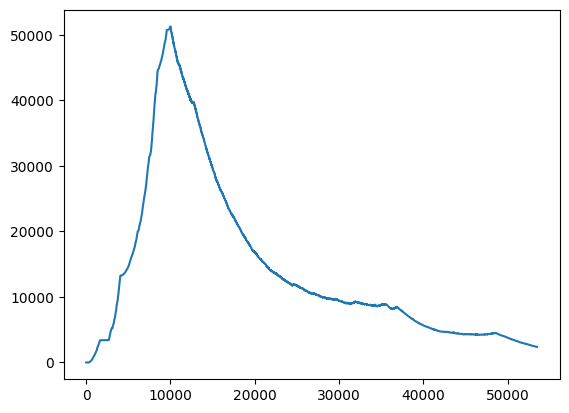

In [79]:
# EXPLOITING THE CLASS TRIEST-BASE
TriestBase(10000).run_triest(data)

Now we want to check the actual number of triangles, so we set M to be the lenght of our dataset (= 88234)

Number of edges:  88234
tau:  1612010
eps:  1
Estimated triangles:  1612010


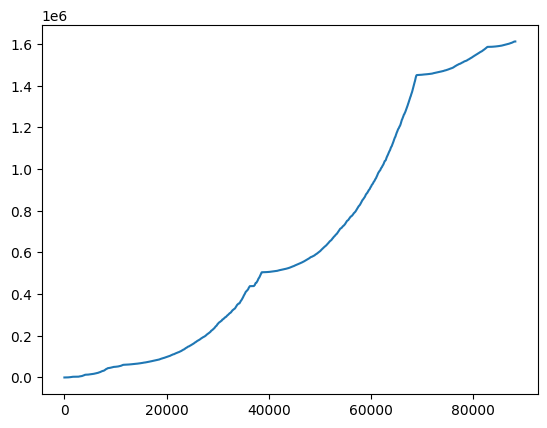

In [80]:
TriestBase(len(data)).run_triest(data)